In [179]:
# 0. Import all libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.layers import Input

In [180]:
# 1. Import data
# Close prices + Other prices + Volumes
file_path = './data/SMCI_merged.csv'
data = pd.read_csv(file_path)

In [181]:
# 2. Preparing Data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index(ascending=True)

columns_to_keep = ['Open', 'High', 'Low', 'Close/Last', 'Volume', 'DPRIME', 'VIX_Close']
data = data[columns_to_keep]

# Subset data for the specified date range
start_date = '2014-06-24'
end_date = '2024-06-21'
data = data[(data.index >= start_date) & (data.index <= end_date)]

In [182]:
# 2. Setup Variables
# 2.1 Time horizon set to be 9 years for training, 1 year for validation
# 2.2 time steps for LSTM
time_steps = 60
test_end_date = '2024-06-21'
# Find the index position of the test_end_date
end_index = data.index.get_loc(test_end_date)
start_index = max(end_index - time_steps, 0)
test_start_date = data.index[start_index]

In [183]:
test_start_date

Timestamp('2024-03-26 00:00:00')

In [184]:
# Filter data for the test date range
test_data = data.loc[test_start_date:test_end_date]

# Calculate the number of data points
num_data_points = len(test_data)

print(num_data_points)

61


In [185]:
# Split data, method 2
# train_set = data[(data.index >= '2014-06-24') & (data.index < '2024-06-19')].copy()
# valid_set = data[(data.index >= '2024-06-20') & (data.index <= '2024-06-21')].copy()

train_set = data[(data.index >= '2014-06-24') & (data.index < '2023-06-24')].copy()
valid_set = data[(data.index >= '2023-06-25') & (data.index < '2024-06-20')].copy()
test_set = data[(data.index >= test_start_date) & (data.index <= test_end_date)].copy()

In [186]:
# 2.3 Feature selection
selected_features = ['Close/Last', 'Volume', 'DPRIME', 'VIX_Close']

num_features = len(selected_features)

In [187]:
def train_and_evaluate_lstm():
    # 3. Data pre-processing
    scalers = {}
    train_data = train_set.copy()
    valid_data = valid_set.copy()

    for feature in selected_features:
        scalers[feature] = MinMaxScaler(feature_range=(0, 1))
        train_data[feature] = scalers[feature].fit_transform(train_set[feature].values.reshape(-1, 1))
        valid_data[feature] = scalers[feature].transform(valid_set[feature].values.reshape(-1, 1))

    # Initialize lists to store training and validation data
    x_train, y_train = [], []
    for i in range(time_steps, len(train_data)):
        x_train.append(train_data[selected_features].values[i-time_steps:i])
        y_train.append(train_data['Close/Last'].values[i])

    x_valid, y_valid = [], []
    for i in range(time_steps, len(valid_data)):
        x_valid.append(valid_data[selected_features].values[i-time_steps:i])
        y_valid.append(valid_data['Close/Last'].values[i])

    # Convert lists to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_valid, y_valid = np.array(x_valid), np.array(y_valid)

    # 4. Build Model - function
    def build_model():
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, len(selected_features))))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    # Build and train model
    model = build_model()
    model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

    # Make Prediction
    predicted_y_valid_normalized = model.predict(x_valid)
    predicted_y_valid = scalers['Close/Last'].inverse_transform(predicted_y_valid_normalized)

    print(f"x_valid.shape: {x_valid.shape}")

    # Calculate RMSE
    valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], predicted_y_valid))
    print(f"LSTM RMSE on validation set: {valid_rmse}")


    # Visualization of results
    plt.figure(figsize=(14, 7))
    plt.plot(train_set.index, train_set['Close/Last'], label='Training Data')
    plt.plot(valid_set.index[time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
    plt.plot(valid_set.index[time_steps:], predicted_y_valid, label='Validation Predictions')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Price Prediction with LSTM (SMCI)')
    plt.legend()
    plt.show()
    
    return model, scalers
    

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.0136e-04 - val_loss: 0.0135
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4185e-04 - val_loss: 0.0147
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.1358e-04 - val_loss: 0.0121
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.3466e-04 - val_loss: 0.0047
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.0785e-04 - val_loss: 0.0032
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0076e-04 - val_loss: 0.0041
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0102e-04 - val_loss: 0.0025
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.9726e-05 - val_loss: 0.0025
Epoch 9/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.1121e-04 - val_loss: 0.0023
Epoch 10/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.5311e-05 - val_loss: 0.0022
Epoch 11/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.9942e-05 - val_loss: 0.0021
Epoch 12/25
63/63 ━━━━━━━━━━━━

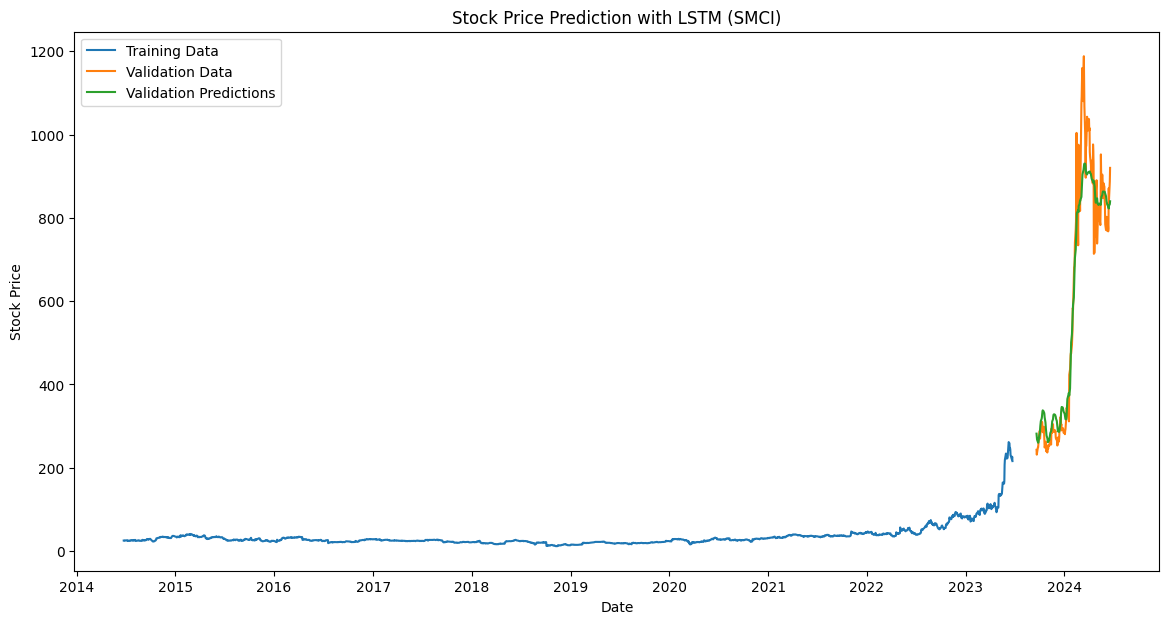

In [188]:
model, scalers = train_and_evaluate_lstm()

In [189]:
def predict_1_day(data_set):
    # Data pre-processing
    predict_data = data_set.copy()
    
    # Apply scalers used in training
    for feature in selected_features:
        predict_data[feature] = scalers[feature].transform(predict_data[feature].values.reshape(-1, 1))

    
    # print(predict_data.shape)
    
    # Prepare the input sequence (last time_steps days)
    x_test = predict_data[selected_features].values[:time_steps]
    # Reshape x_test to (1, time_steps, num_features)
    x_test = x_test.reshape(1, time_steps, len(selected_features))
    
    # print(last_sequence)
    # print(x_test.shape)
    
    # Make prediction for the next day
    predicted_y_next_day_normalized = model.predict(x_test)
    predicted_y_next_day = scalers['Close/Last'].inverse_transform(predicted_y_next_day_normalized)

    return predicted_y_next_day[0][0]

In [190]:
# Extract the actual value of the last day
actual_y_next_day = test_set['Close/Last'].values[-1]

In [191]:
# # Container to hold predictions
# predictions = []
# 
# # Perform 10 iterations
# for _ in range(10):
#     prediction = predict_1_day(test_set)
#     predictions.append(prediction)

In [192]:
prediction_next_day = predict_1_day(test_set)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [193]:
actual_y_next_day

905.26

In [194]:
# # Plot predicted prices
# # Visualization of results
# plt.figure(figsize=(8, 4))
# plt.plot(range(1, len(predictions) + 1), predictions, marker='o', label='Predicted Prices')
# 
# # Add a horizontal line for actual_y_next_day
# plt.axhline(y=actual_y_next_day, color='green', linestyle='--', label='Actual Value')
# 
# plt.xticks(ticks=range(1, len(predictions) + 1))
# plt.xlabel('Prediction Number')
# plt.ylabel('Predicted Stock Price')
# plt.title('All Stock Price Prediction with LSTM (SMCI)')
# plt.legend()
# plt.show()

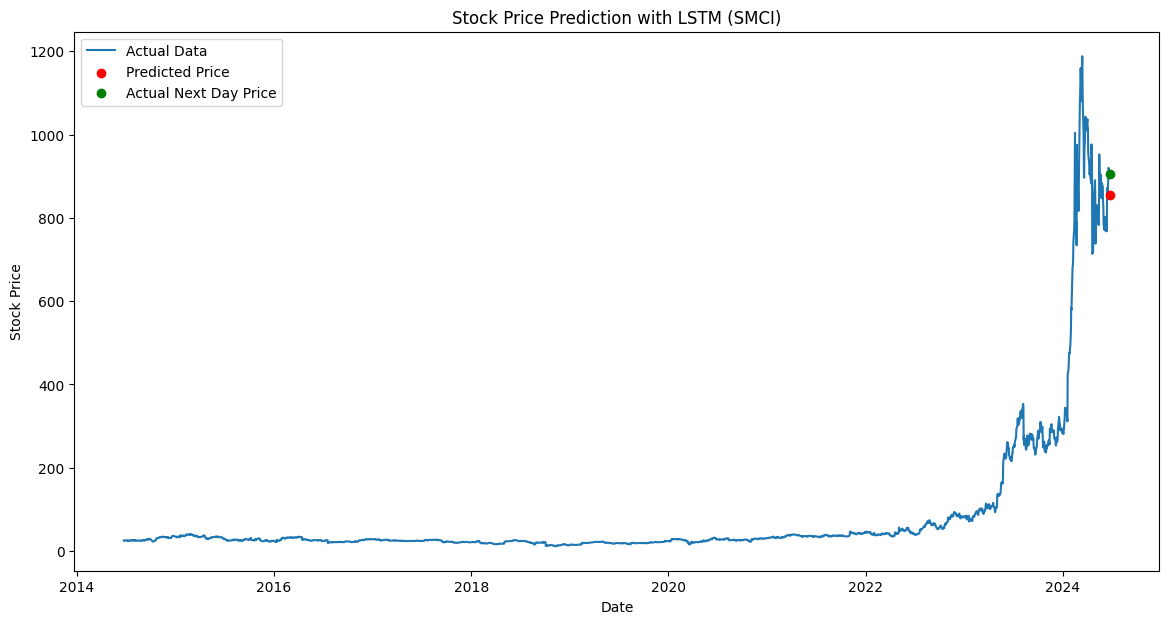

In [195]:
# Calculate average prediction
# prediction_avg = np.mean(predictions)
prediction_avg = prediction_next_day

# Get the last date for plotting
last_date = data.index[-1]

# Generate the next working day for prediction
next_working_day = last_date + pd.tseries.offsets.BDay(1)

# Visualization of results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close/Last'], label='Actual Data')

# Plot prediction
plt.scatter(next_working_day, prediction_avg, color='red', label='Predicted Price', zorder=5)

# Plot actual value for the next day
plt.scatter(next_working_day, actual_y_next_day, color='green', label='Actual Next Day Price', zorder=5)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM (SMCI)')
plt.legend()
plt.show()